In [39]:
import torch
import numpy as np
from skimage import io
import torch.optim as optim
from torch.utils.data import Dataset
import torchvision
from torchvision import transforms

from matplotlib import pyplot as plt

from PIL import Image

from progan.modeling import GANConfiguration
from progan.loss import GANLoss
from progan.trainer import TrainingArguments, GANTrainer

In [40]:
compose = transforms.Compose([
            torchvision.transforms.RandomAffine(degrees = 15, translate = (0.1, 0.1), scale = (1., 1.2), fillcolor=0),
            torchvision.transforms.ColorJitter(0.2, 0.3, 1),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            torchvision.transforms.Normalize(0.5, 0.5),

        ])

C:\Users\Louis\miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:1328: UserWarning: Argument fillcolor is deprecated and will be removed since v0.10.0. Please, use fill instead
  warnings.warn(


In [41]:
DATA_DIR = './ultra-sun-ultra-moon'

LEARNING_RATE = 1e-3
LAMBDA_GP = 10


In [42]:
def custom_loader(path):
    with open(path, 'rb') as f:
        img = Image.open(f)
        rgba = np.array(img)
        rgba[rgba[...,-1]==0] = [0,0,0,0]
        img = Image.fromarray(rgba)
        return img.convert('RGB')

In [43]:
dataset = torchvision.datasets.ImageFolder(DATA_DIR, transform=compose, loader=custom_loader)

In [44]:
transform = transforms.Compose([
            transforms.Scale((128, 128)),
            transforms.ToTensor(),
            torchvision.transforms.Normalize(0.5, 0.5),

        ])

C:\Users\Louis\miniconda3\envs\pytorch\lib\site-packages\torchvision\transforms\transforms.py:285: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [50]:
celeba = torchvision.datasets.ImageFolder(root="./img_align_celeba", transform = transform)

In [51]:
dataloader = torch.utils.data.DataLoader(celeba,
                        batch_size=8,
                        shuffle=True,
                    )

dataiter = iter(dataloader)


In [52]:
# Function used to plot data from the loaders
def imshow(img, **kwargs):
    img = (img+1)/2    # unnormalize
    npimg = img.numpy() # get tensor as a numpy array
    plt.figure(**kwargs)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [53]:
data, labels = next(dataiter)
print(data[0].shape)

torch.Size([3, 128, 128])


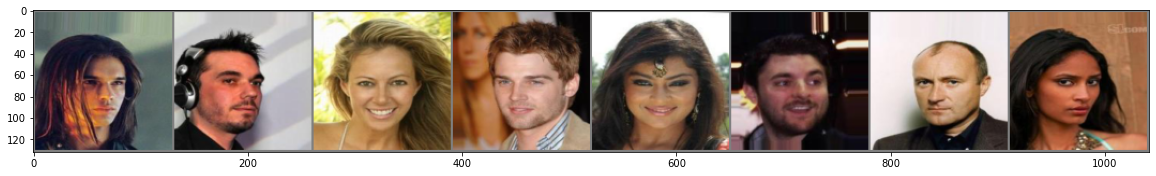

In [54]:
imshow(torchvision.utils.make_grid(data), figsize=(20,20))

In [57]:
gan_config = GANConfiguration()

In [58]:
gan_config.save("configs/default_gan")

In [59]:
generator, discriminator = gan_config.build_gan()

In [60]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

generator.to(device)
discriminator.to(device)

print(f"Device : {device}")

Device : cuda:0


In [61]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=LEARNING_RATE, betas=(0, 0.99))
g_optimizer = optim.Adam(generator.parameters(), lr=LEARNING_RATE, betas=(0, 0.99))

In [62]:
gan_loss = GANLoss(g_optimizer, d_optimizer, LAMBDA_GP)

In [63]:
training_args = TrainingArguments(save_steps = 1000, checkpoint_imgs=32)

In [64]:
trainer = GANTrainer(discriminator, generator, gan_loss, dataset, training_args)

In [65]:
trainer.train()

Training : Rank 4 = 64x64:  15%|█▌        | 6000/40000 [00:00<?, ?it/s]

KeyboardInterrupt: 